# Imports

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import joblib
import lightgbm as lgb
import shap

%matplotlib inline

# Load Data

In [185]:
games = pd.read_csv('data/games.csv')
turns = pd.read_csv('data/turns.csv')

full_df = pd.read_csv('predictions/merged.csv')
val_predictions = pd.read_csv('predictions/val_predictions.csv')

# Turns Dataset

In [186]:
turns

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play
...,...,...,...,...,...,...,...,...,...
2005493,72773,22,adola,ABINRRU,15N,IN,18,376,Play
2005494,72773,23,HastyBot,EGHIIP,H12,.HIG,24,331,Play
2005495,72773,24,adola,ABRRU,15E,BRA.,7,383,Play
2005496,72773,25,HastyBot,EIP,7A,PIE,11,342,Play


In [187]:
turns['points'].sort_values()

1924006   -221
1913474   -221
1365496   -221
1860699   -203
805216    -203
          ... 
369530     248
737219     293
1732561    302
692626     302
312416     311
Name: points, Length: 2005498, dtype: int64

Apparently, there are cases where a negative score occurs. Let's delve deeper to understand why.

In [188]:
exchange_rows = turns[(turns['turn_type'] == 'Exchange') & (turns['points'] < 0)]
exchange_row_indices = exchange_rows.index
previous_row_indices = exchange_row_indices - 1
all_indices = pd.Index(exchange_row_indices.union(previous_row_indices))
all_indices = all_indices[all_indices >= 0]
desired_rows = turns.loc[all_indices]
desired_rows

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
534,20,4,Favournew,AKRRTXY,11D,TAXY,45,64,Play
535,20,5,Favournew,AKRRTXY,NaN,--,-45,19,Exchange
832,31,6,AWFUL,?EIILRS,15H,.ISLIERs,80,138,Play
833,31,7,AWFUL,?EIILRS,NaN,--,-80,58,Exchange
1003,37,23,derickalim,DGIRSUZ,A8,ZIGS,49,410,Play
...,...,...,...,...,...,...,...,...,...
2005151,72761,37,hulkbuster,ABEIOST,NaN,--,-30,210,Exchange
2005358,72769,11,browndav,CEEILTV,E3,LECTIVE,78,227,Play
2005359,72769,12,browndav,CEEILTV,NaN,--,-78,149,Exchange
2005361,72769,14,browndav,CEEILTV,14B,CLIVE,28,177,Play


Upon examining the instances of negative scoring, we identify two potential causes:

1. A negative score arising due to the expiration of the turn's time limit, where the player failed to make a move.
2. Negative points incurred when a player submits a non-existent word, initially receiving points for it, only to have these points deducted in the subsequent turn.

# Residual Analysis:
## 1. Calculating Error and Absolute Error

In [189]:
val_predictions['abs_error'] = np.abs(val_predictions['rating'] - val_predictions['pred_rating'])
val_predictions['error'] = val_predictions['rating'] - val_predictions['pred_rating']

val_predictions_sorted = val_predictions[['game_id', 'rating', 'pred_rating', 'abs_error', 'error']].sort_values('abs_error', ascending=False)
print(f'Abs Error Mean {val_predictions_sorted["abs_error"].mean()}, Error Mean {val_predictions["error"].mean()}')
val_predictions_sorted

Abs Error Mean 53.29233762920853, Error Mean -0.4959727070617083


,game_id,rating,pred_rating,abs_error,error
36178,28891,1166.0,2078.252019,912.252019,-912.252019
14056,25779,1182.0,2016.544594,834.544594,-834.544594
548,35585,1299.0,2124.204288,825.204288,-825.204288
15559,3505,1352.0,2112.718644,760.718644,-760.718644
16735,18110,1341.0,2032.905005,691.905005,-691.905005
...,...,...,...,...,...
2222,17185,1829.0,1829.008115,0.008115,-0.008115
2828,35903,2213.0,2212.994566,0.005434,0.005434
28776,67180,2115.0,2115.001793,0.001793,-0.001793
20404,13950,2228.0,2227.998572,0.001428,0.001428


In [190]:
merged = pd.merge(games, val_predictions)

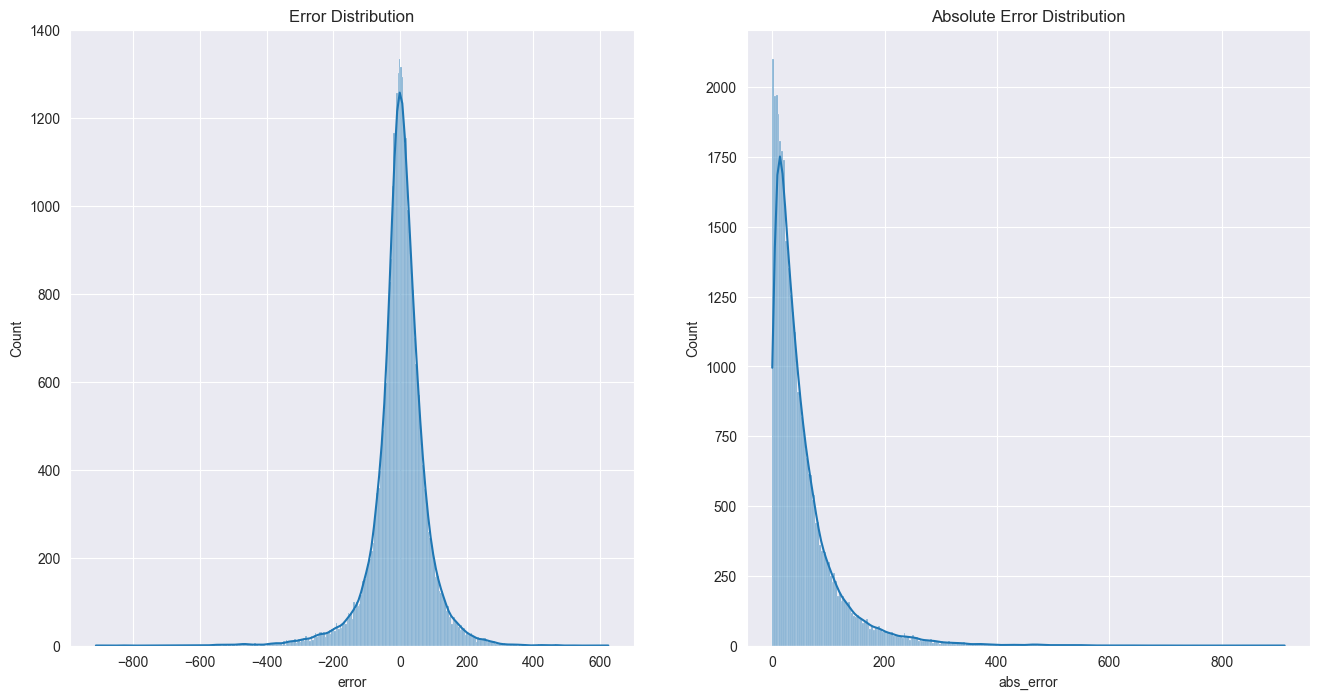

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.histplot(merged['error'], kde=True, ax=ax[0])
ax[0].set_title('Error Distribution')

sns.histplot(merged['abs_error'], kde=True, ax=ax[1])
ax[1].set_title('Absolute Error Distribution')

plt.show()

Analyzing the error distribution reveals two types of inaccuracies: cases where the model overestimates and those where it underestimates the actual rating. The maximum overestimation by the model is by 912 points, while the greatest underestimation is by 624 points. Additionally, the average error margin is approximately -0.49 points.

## 2. Lexicon Feature

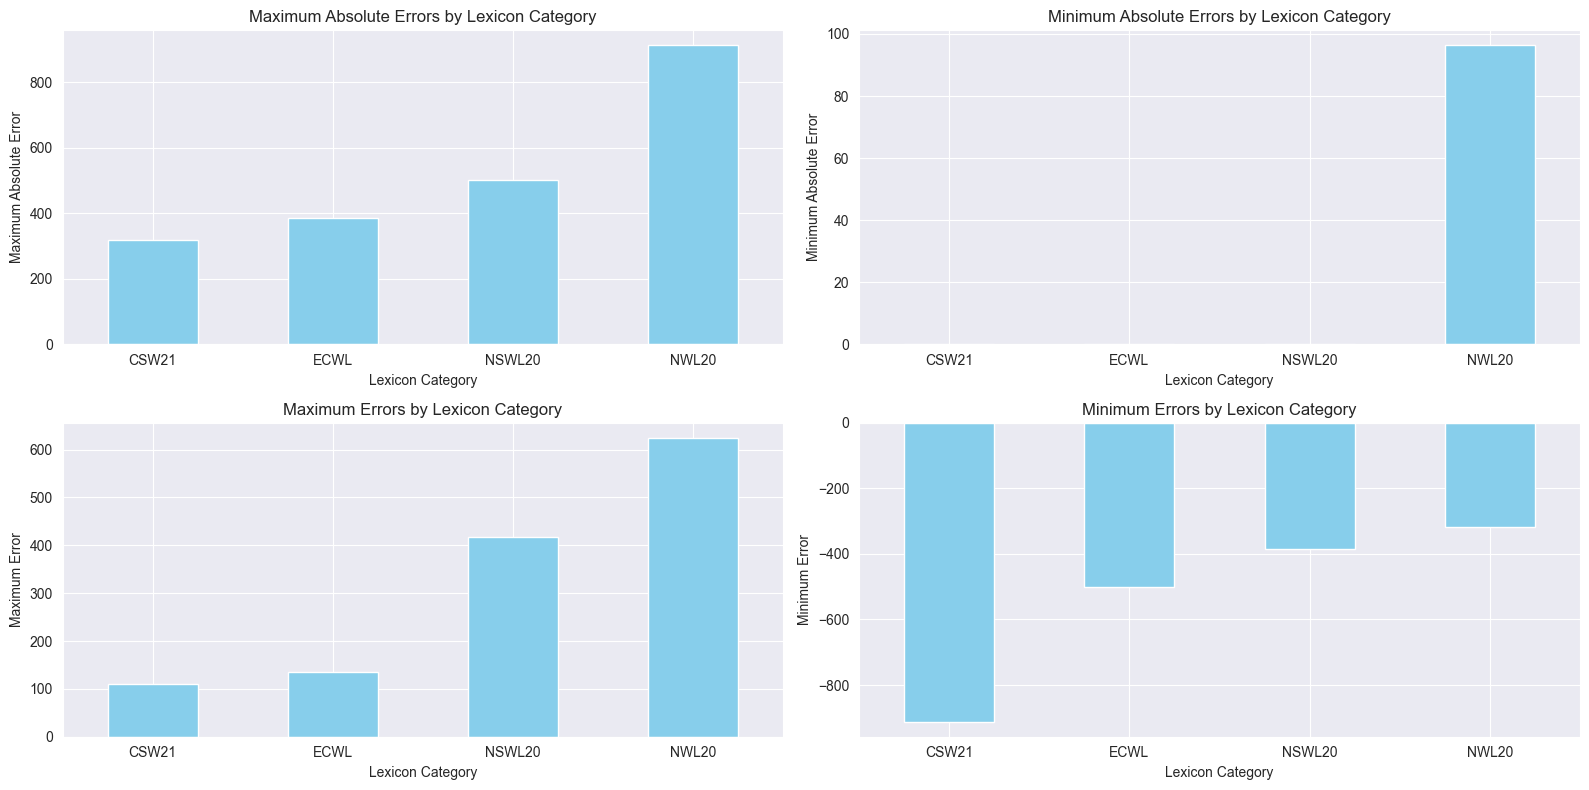

In [192]:
merged_lexicon = pd.merge(games[['game_id', 'lexicon']], val_predictions_sorted)
max_abs_errors_lexicon = merged.groupby('lexicon').agg({'abs_error': ['min', 'max']})
max_abs_errors_lexicon.columns = ['_'.join(col).strip() for col in max_abs_errors_lexicon.columns.values]

max_errors_lexicon = merged_lexicon.groupby('lexicon').agg({'error': ['min', 'max']})
max_errors_lexicon.columns = ['_'.join(col).strip() for col in max_errors_lexicon.columns.values]

_, ax = plt.subplots(2, 2, figsize=(16, 8))

max_abs_errors_lexicon['abs_error_max'].sort_values().plot(kind='bar', color='skyblue', ax=ax[0, 0])
ax[0, 0].set_xlabel('Lexicon Category')
ax[0, 0].set_ylabel('Maximum Absolute Error')
ax[0, 0].set_title('Maximum Absolute Errors by Lexicon Category')
ax[0, 0].set_xticklabels(max_abs_errors_lexicon.index, rotation=360)

max_abs_errors_lexicon['abs_error_min'].sort_values().plot(kind='bar', color='skyblue', ax=ax[0, 1])
ax[0, 1].set_xlabel('Lexicon Category')
ax[0, 1].set_ylabel('Minimum Absolute Error')
ax[0, 1].set_title('Minimum Absolute Errors by Lexicon Category')
ax[0, 1].set_xticklabels(max_abs_errors_lexicon.index, rotation=360)

max_errors_lexicon['error_max'].sort_values().plot(kind='bar', color='skyblue', ax=ax[1, 0])
ax[1, 0].set_xlabel('Lexicon Category')
ax[1, 0].set_ylabel('Maximum Error')
ax[1, 0].set_title('Maximum Errors by Lexicon Category')
ax[1, 0].set_xticklabels(max_errors_lexicon.index, rotation=360)

max_errors_lexicon['error_min'].sort_values().plot(kind='bar', color='skyblue', ax=ax[1, 1])
ax[1, 1].set_xlabel('Lexicon Category')
ax[1, 1].set_ylabel('Minimum Error')
ax[1, 1].set_title('Minimum Errors by Lexicon Category')
ax[1, 1].set_xticklabels(max_errors_lexicon.index, rotation=360)

plt.tight_layout()
plt.show()

It is evident that the lexicon exhibiting the highest absolute error is NWL20. Upon further investigation, it becomes clear that NWL20 also has the highest error in terms of underestimating the actual rating. Conversely, the lexicon with the most significant negative error, implying an overestimation of the actual rating, is CSW21.

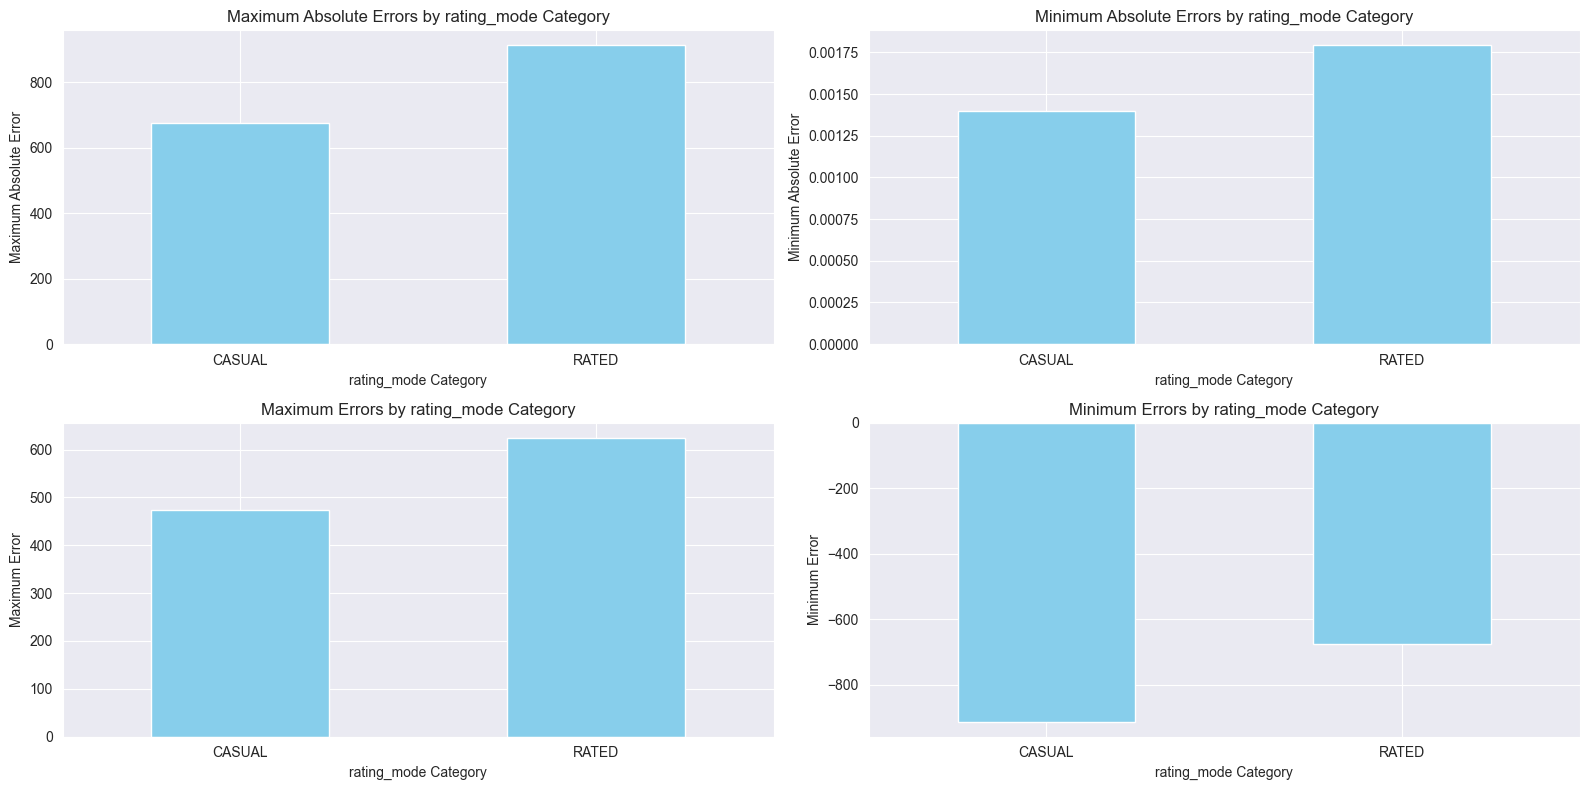

In [193]:
merged_rating_mode = pd.merge(games[['game_id', 'rating_mode']], val_predictions_sorted)
max_abs_errors_rating_mode = merged_rating_mode.groupby('rating_mode').agg({'abs_error': ['min', 'max']})
max_abs_errors_rating_mode.columns = ['_'.join(col).strip() for col in max_abs_errors_rating_mode.columns.values]

max_errors_rating_mode = merged_rating_mode.groupby('rating_mode').agg({'error': ['min', 'max']})
max_errors_rating_mode.columns = ['_'.join(col).strip() for col in max_errors_rating_mode.columns.values]

_, ax = plt.subplots(2, 2, figsize=(16, 8))

max_abs_errors_rating_mode['abs_error_max'].sort_values().plot(kind='bar', color='skyblue', ax=ax[0, 0])
ax[0, 0].set_xlabel('rating_mode Category')
ax[0, 0].set_ylabel('Maximum Absolute Error')
ax[0, 0].set_title('Maximum Absolute Errors by rating_mode Category')
ax[0, 0].set_xticklabels(max_abs_errors_rating_mode.index, rotation=360)

max_abs_errors_rating_mode['abs_error_min'].sort_values().plot(kind='bar', color='skyblue', ax=ax[0, 1])
ax[0, 1].set_xlabel('rating_mode Category')
ax[0, 1].set_ylabel('Minimum Absolute Error')
ax[0, 1].set_title('Minimum Absolute Errors by rating_mode Category')
ax[0, 1].set_xticklabels(max_abs_errors_rating_mode.index, rotation=360)

max_errors_rating_mode['error_max'].sort_values().plot(kind='bar', color='skyblue', ax=ax[1, 0])
ax[1, 0].set_xlabel('rating_mode Category')
ax[1, 0].set_ylabel('Maximum Error')
ax[1, 0].set_title('Maximum Errors by rating_mode Category')
ax[1, 0].set_xticklabels(max_errors_rating_mode.index, rotation=360)

max_errors_rating_mode['error_min'].sort_values().plot(kind='bar', color='skyblue', ax=ax[1, 1])
ax[1, 1].set_xlabel('rating_mode Category')
ax[1, 1].set_ylabel('Minimum Error')
ax[1, 1].set_title('Minimum Errors by rating_mode Category')
ax[1, 1].set_xticklabels(max_errors_rating_mode.index, rotation=360)

plt.tight_layout()
plt.show()

Examining the rating_mode, it is observed that 'RATED' has the highest absolute error. A deeper analysis reveals that the distinction for the highest error, characterized by underestimating the actual rating, is narrowly shared between 'rated' and 'casual'. On the other hand, the rating mode most associated with the highest negative error, indicative of overestimating the actual rating, is predominantly 'casual'.

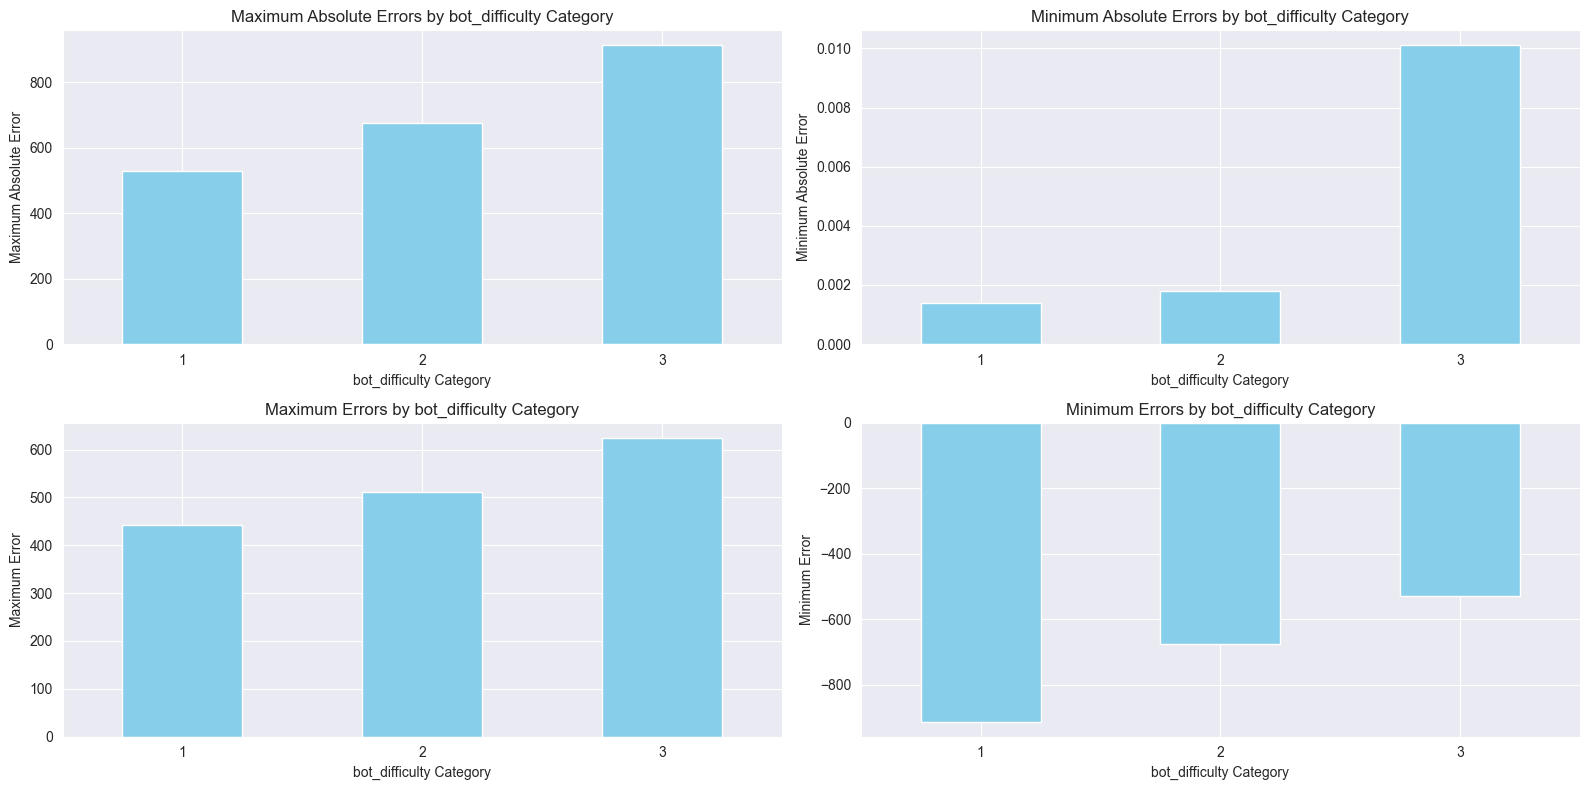

In [194]:
max_abs_errors_bot_difficulty = merged.groupby('bot_difficulty').agg({'abs_error': ['min', 'max']})
max_abs_errors_bot_difficulty.columns = ['_'.join(col).strip() for col in max_abs_errors_bot_difficulty.columns.values]

max_errors_bot_difficulty = merged.groupby('bot_difficulty').agg({'error': ['min', 'max']})
max_errors_bot_difficulty.columns = ['_'.join(col).strip() for col in max_errors_bot_difficulty.columns.values]

_, ax = plt.subplots(2, 2, figsize=(16, 8))

max_abs_errors_bot_difficulty['abs_error_max'].sort_values().plot(kind='bar', color='skyblue', ax=ax[0, 0])
ax[0, 0].set_xlabel('bot_difficulty Category')
ax[0, 0].set_ylabel('Maximum Absolute Error')
ax[0, 0].set_title('Maximum Absolute Errors by bot_difficulty Category')
ax[0, 0].set_xticklabels(max_abs_errors_bot_difficulty.index, rotation=360)

max_abs_errors_bot_difficulty['abs_error_min'].sort_values().plot(kind='bar', color='skyblue', ax=ax[0, 1])
ax[0, 1].set_xlabel('bot_difficulty Category')
ax[0, 1].set_ylabel('Minimum Absolute Error')
ax[0, 1].set_title('Minimum Absolute Errors by bot_difficulty Category')
ax[0, 1].set_xticklabels(max_abs_errors_bot_difficulty.index, rotation=360)

max_errors_bot_difficulty['error_max'].sort_values().plot(kind='bar', color='skyblue', ax=ax[1, 0])
ax[1, 0].set_xlabel('bot_difficulty Category')
ax[1, 0].set_ylabel('Maximum Error')
ax[1, 0].set_title('Maximum Errors by bot_difficulty Category')
ax[1, 0].set_xticklabels(max_errors_bot_difficulty.index, rotation=360)

max_errors_bot_difficulty['error_min'].sort_values().plot(kind='bar', color='skyblue', ax=ax[1, 1])
ax[1, 1].set_xlabel('bot_difficulty Category')
ax[1, 1].set_ylabel('Minimum Error')
ax[1, 1].set_title('Minimum Errors by bot_difficulty Category')
ax[1, 1].set_xticklabels(max_errors_bot_difficulty.index, rotation=360)

plt.tight_layout()
plt.show()

The plots indicate that the level of bot difficulty has a significant impact on the model's prediction of ratings. Specifically, a bot difficulty setting of 3 leads the model to predict higher ratings, whereas a setting of 1 results in lower predicted ratings.

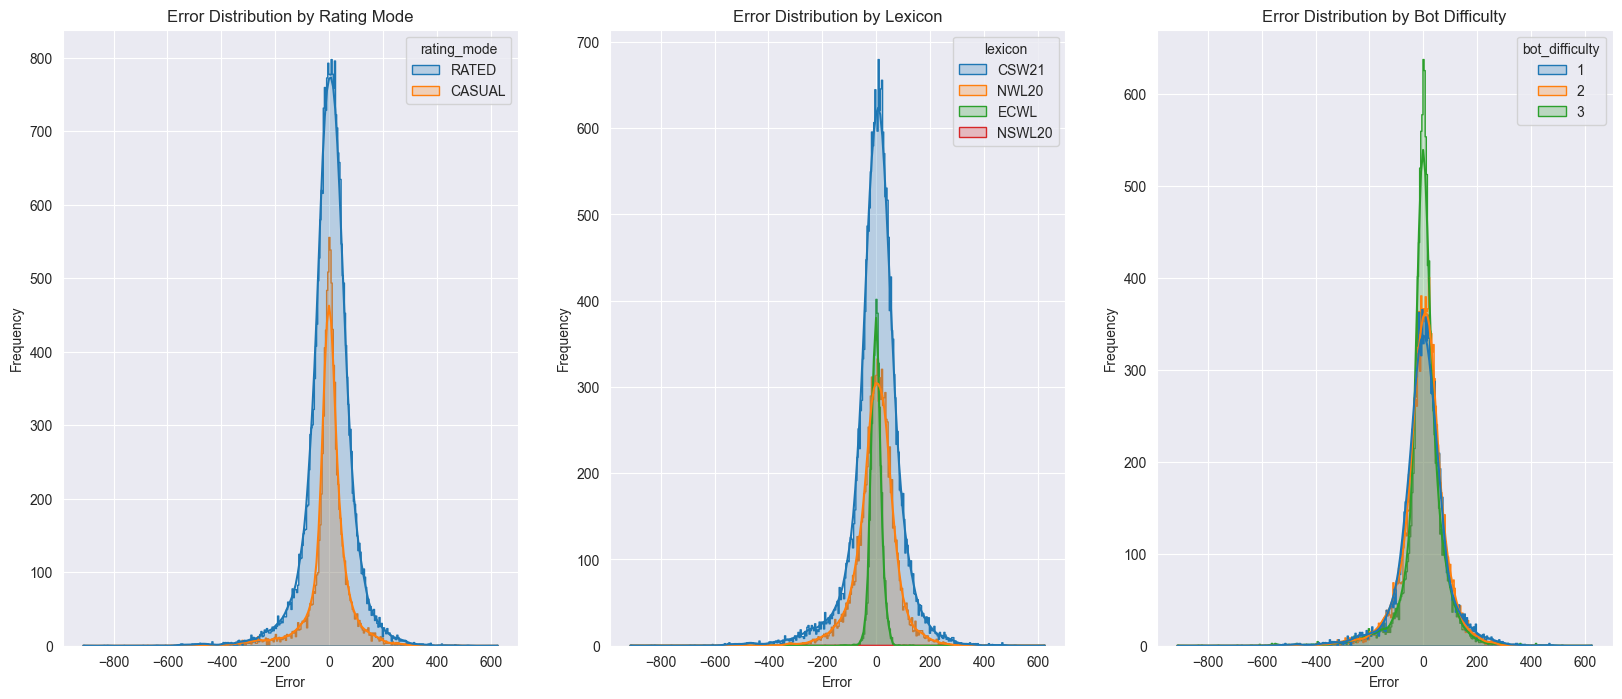

In [255]:
_, ax = plt.subplots(1, 3, figsize=(20, 8))
merged['bot_difficulty'] = merged['bot_difficulty'].astype('string')

sns.histplot(data=merged, x="error", hue="rating_mode", element="step", kde=True, ax=ax[0])
ax[0].set_title("Error Distribution by Rating Mode")
ax[0].set_xlabel("Error")
ax[0].set_ylabel("Frequency")

sns.histplot(data=merged, x="error", hue="lexicon", element="step", kde=True, ax=ax[1])
ax[1].set_title("Error Distribution by Lexicon")
ax[1].set_xlabel("Error")
ax[1].set_ylabel("Frequency")

sns.histplot(data=merged, x="error", hue="bot_difficulty", element="step", kde=True, ax=ax[2])
ax[2].set_title("Error Distribution by Bot Difficulty")
ax[2].set_xlabel("Error")
ax[2].set_ylabel("Frequency")
plt.show()

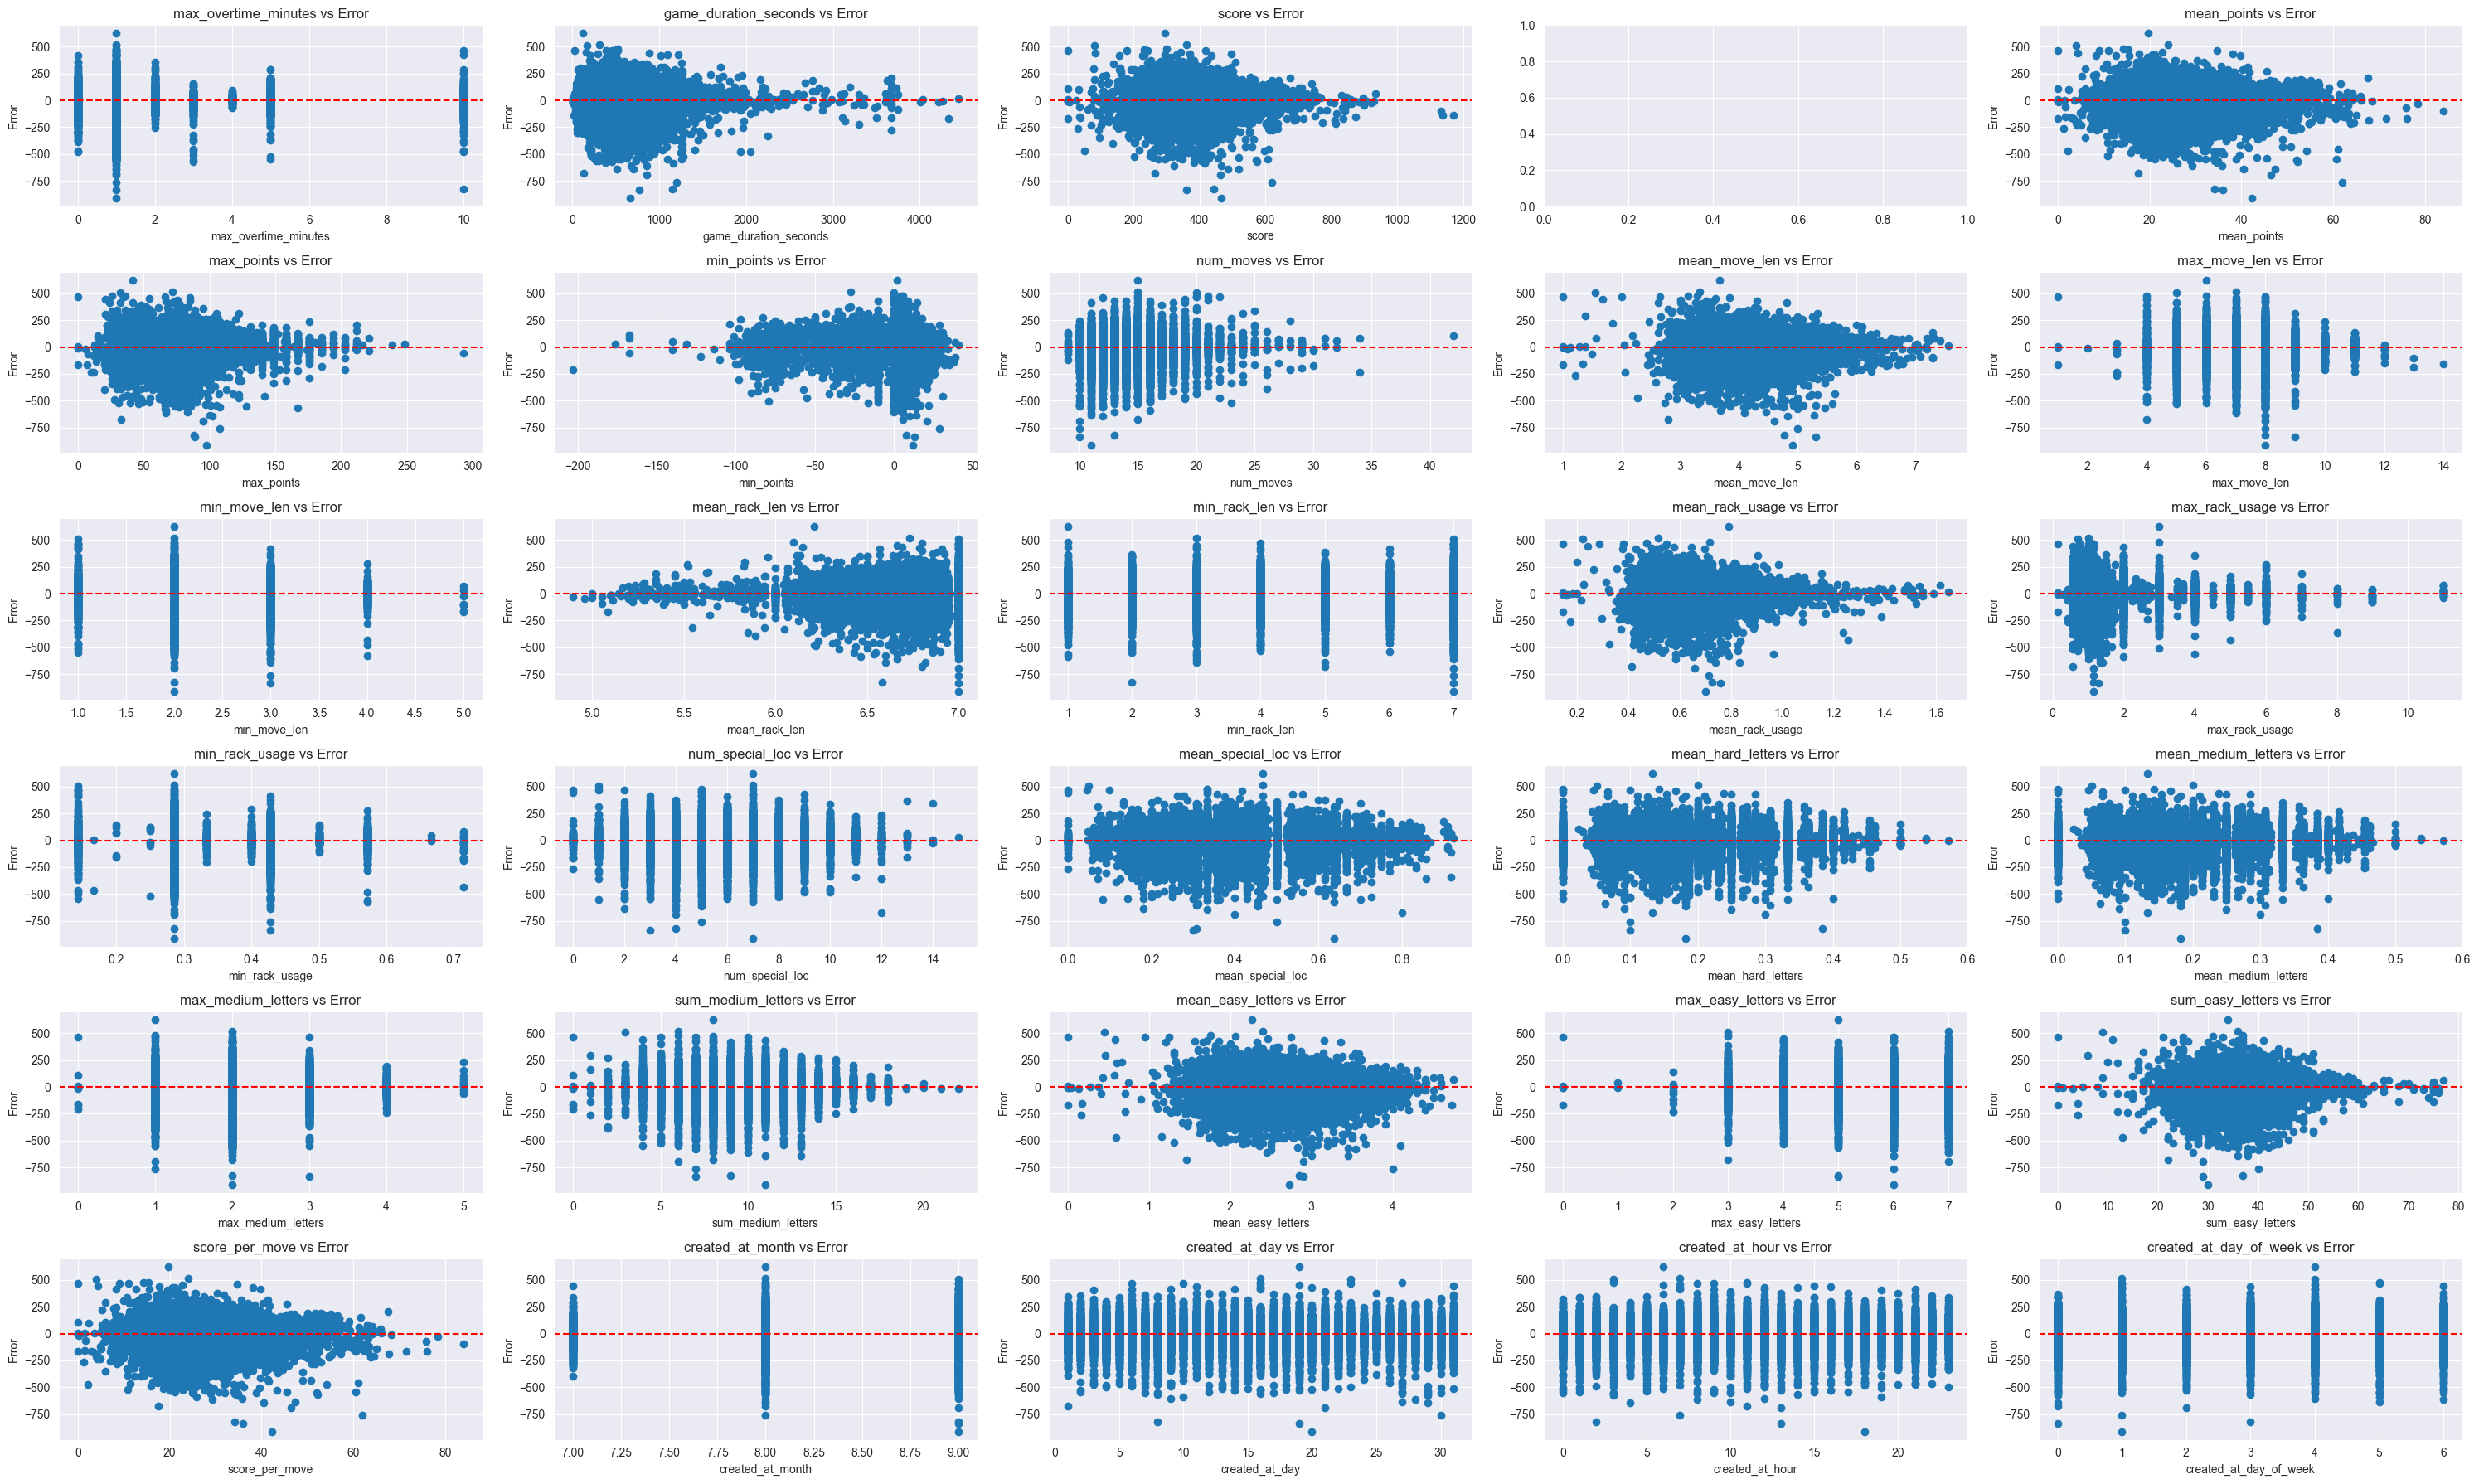

In [196]:
_, ax = plt.subplots(6, 5, figsize=(30, 18))

columns = merged.columns[10:40]

for i, (column) in enumerate(columns):
    if column == 'rating':
        continue
    row = i // 5
    col = i % 5
    ax[row, col].scatter(merged[column], merged['error'])
    ax[row, col].set_xlabel(column)
    ax[row, col].set_ylabel('Error')
    ax[row, col].axhline(y=0, color='red', linestyle='--')
    ax[row, col].set_title(f'{column} vs Error')

plt.tight_layout()
plt.show()

The plots, with various features on the x-axis and error on the y-axis, show that no single feature stands out as a major cause of either overestimates or underestimates.

# Model Explainability using SHAP

In [198]:
catboost = CatBoostRegressor()
catboost.load_model('models/catboost_model.cbm')

In [199]:
X = full_df.drop(['game_id', 'rating'], axis=1)

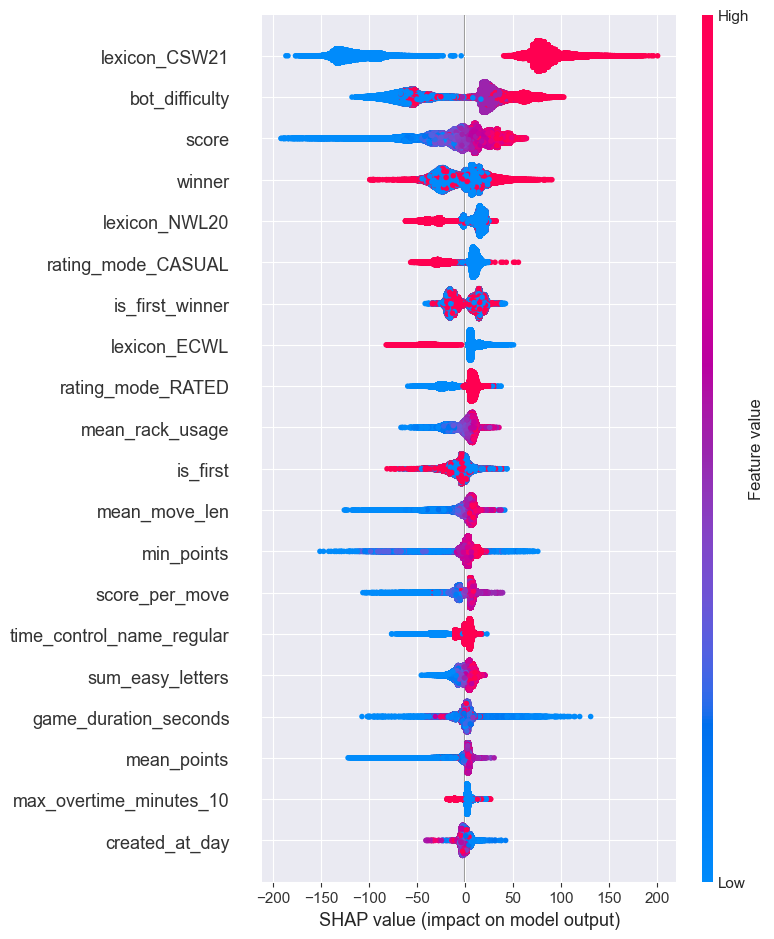

In [200]:
shap.initjs()
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

The beeswarm plot of SHAP values clearly indicates that the feature 'lexicon_CSW21' has the most significant impact on the prediction. When this feature is set to 1, it tends to result in a higher rating, whereas a value of 0 corresponds to a lower rating. The feature 'bot_difficulty' exhibits a similar effect, albeit to a lesser extent. Conversely, 'lexicon_ECWL' demonstrates an inverse effect compared to 'lexicon_CSW21'.

## No Mistakes

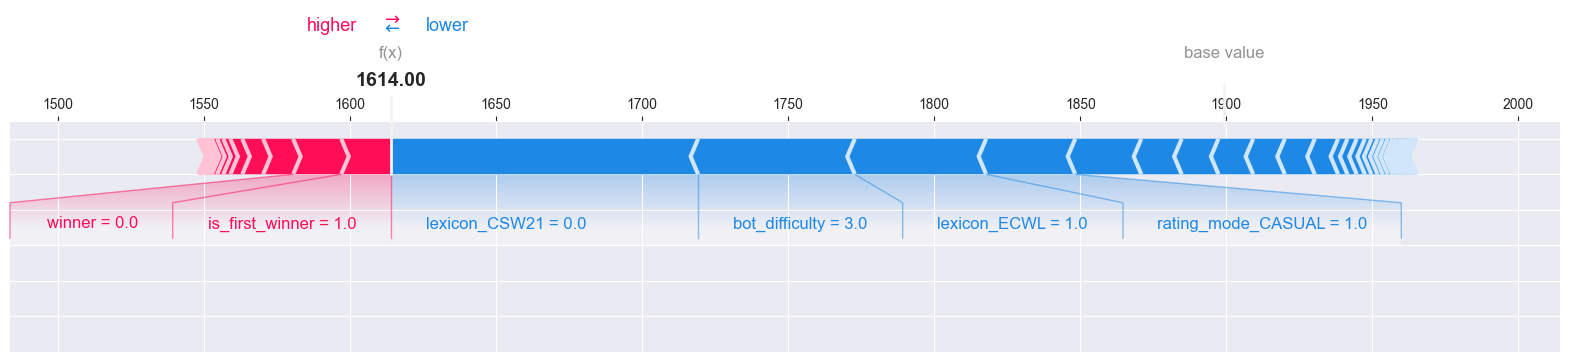

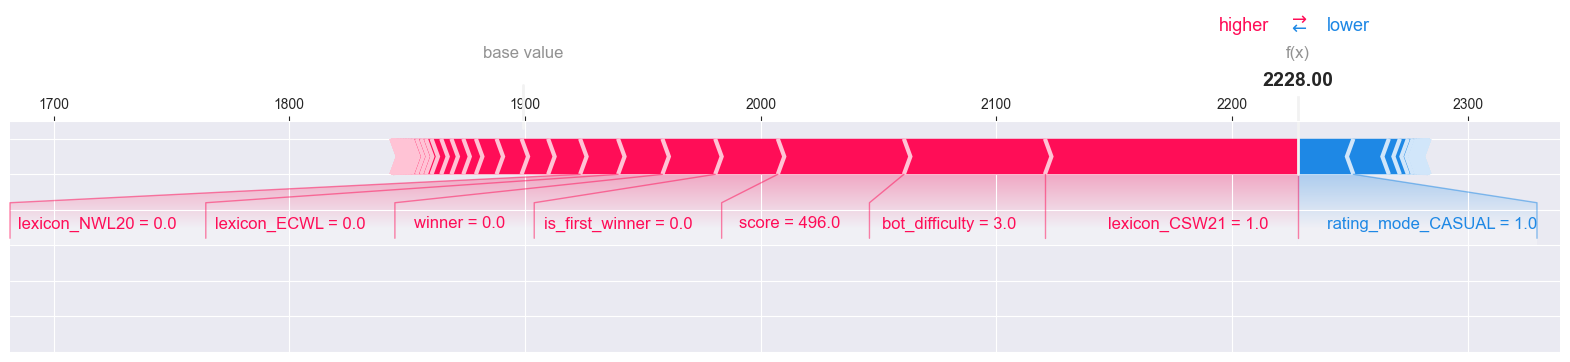

In [250]:
instance_indices = [42410, 27898]

for i in instance_indices:
    shap.plots.force(explainer.expected_value, shap_values[i], X.iloc[i], feature_names=X.columns,
                    matplotlib=True, show=False)

plt.show()

## Negative Mistake

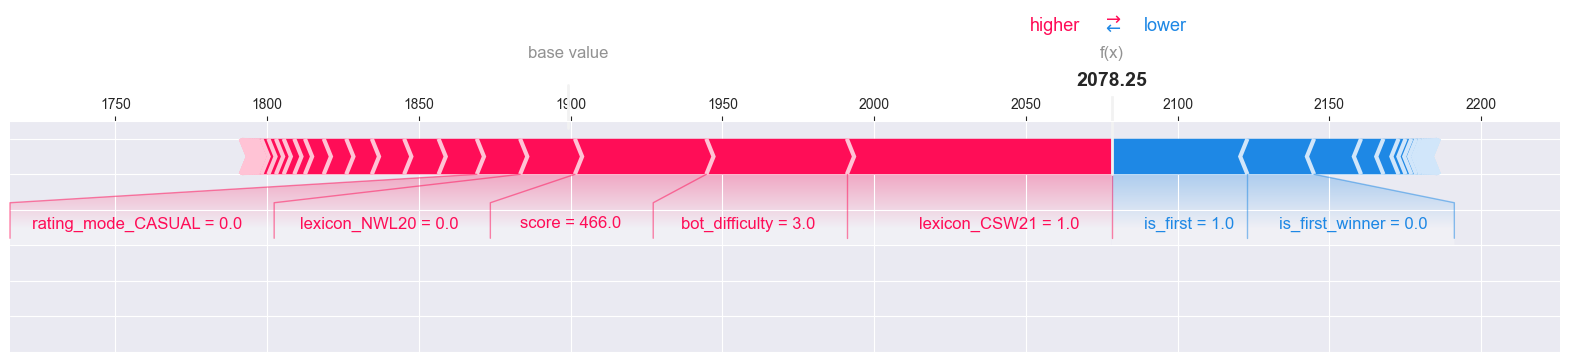

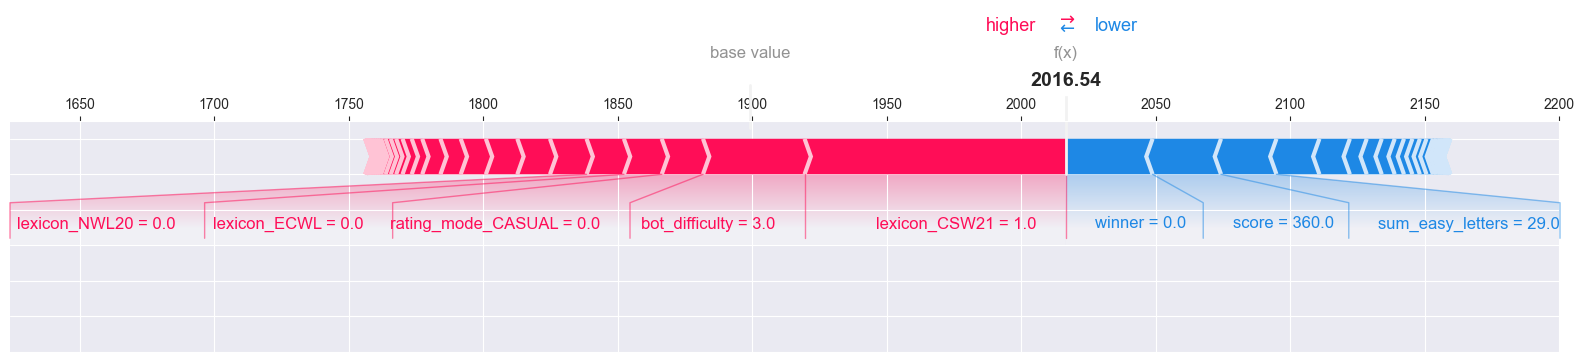

In [224]:
instance_indices = [57781, 51556]

for i in instance_indices:
    shap.plots.force(explainer.expected_value, shap_values[i], X.iloc[i], feature_names=X.columns,
                    matplotlib=True, show=False)

plt.show()

## Positive Mistakes

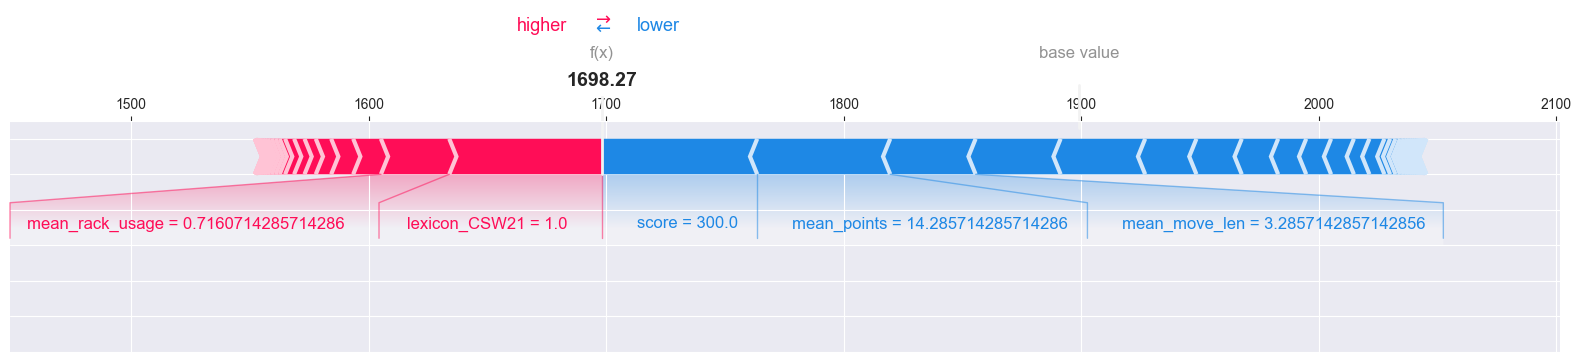

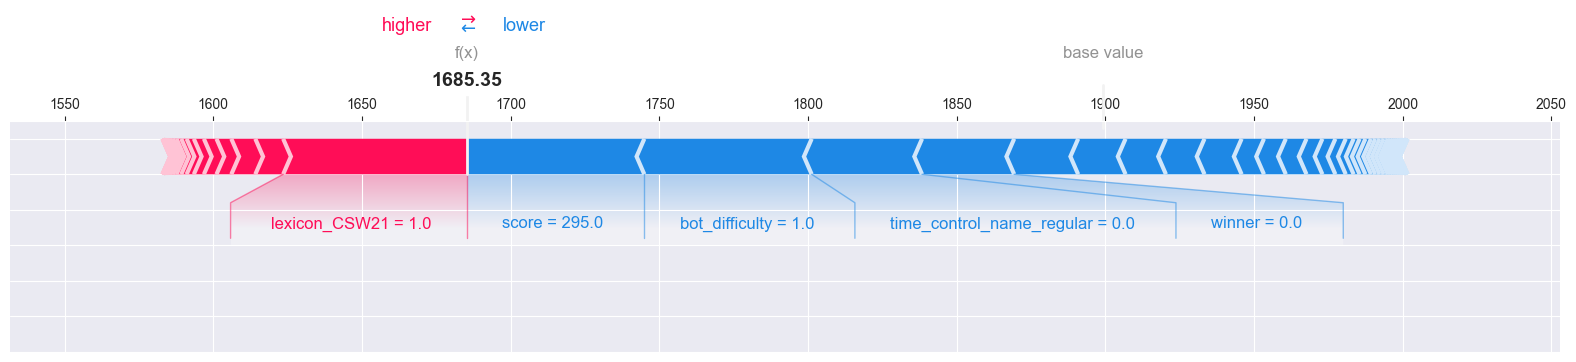

In [225]:
instance_indices = [29270, 83091]
for i in instance_indices:
    shap.plots.force(explainer.expected_value, shap_values[i], X.iloc[i], feature_names=X.columns,
                    matplotlib=True, show=False)

plt.show()